In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/C247-NNDL/

/content/drive/MyDrive/C247-NNDL


# IMPORTS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib.collections import LineCollection
from numpy.random import choice

from sklearn.metrics import accuracy_score

%pylab inline

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as T
import torch.nn.functional as F

from torchsummary import summary

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir="Results/runs")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Populating the interactive namespace from numpy and matplotlib


# DATA PREPROCESSING AND RESHAPING

In [ ]:
## Loading the numpy arrays corresponding to the EEG dataset

X_test = np.load("./Dataset/X_test.npy")
y_test = np.load("./Dataset/y_test.npy")
person_train_valid = np.load("./Dataset/person_train_valid.npy")
X_train_valid = np.load("./Dataset/X_train_valid.npy")
y_train_valid = np.load("./Dataset/y_train_valid.npy")
person_test = np.load("./Dataset/person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

# DATA PREPROCESSING AND AUGMENTATION

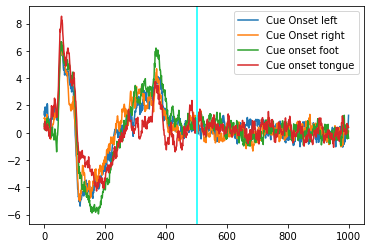

In [ ]:

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [ ]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

In [ ]:
## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)


# CREATING TRAIN AND VALIDATION

WITH PREPROCESSING AND AUGMENTATION

In [ ]:
## Creating the training and validation sets

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

X_test = X_test_prep
y_test = y_test_prep

print('Shape of test set:',X_test.shape)
print('Shape of test labels:',y_test.shape)

Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of test set: (1772, 22, 250)
Shape of test labels: (1772,)


WITHOUT PREPROCESSING AND AUGMENTATION

In [ ]:
## Creating the training and validation sets

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

Shape of training set: (1615, 22, 1000)
Shape of validation set: (500, 22, 1000)
Shape of training labels: (1615,)
Shape of validation labels: (500,)


In [ ]:
# Adding width of the segment to be 1

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)

Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width info: (1772, 22, 250, 1)


# VISUALIZING A SAMPLE EEG DATA

In [ ]:
# Taken from: https://notebook.community/joannekoong/neuroscience_tutorials/basic/1.%20Load%20EEG%20data%20and%20plot%20ERP

def plot_eeg(EEG, vspace=100, color='k'):   
    bases = vspace * np.arange(22)    
    EEG = EEG.T + bases
    
    # Calculate a timeline in seconds, assuming that the sample rate of the EEG recorder was 2048 Hz.
    samplerate = 2048
    time = arange(EEG.shape[0]) / samplerate
    
    # Plot EEG versus time
    plot(time, EEG, color=color)
    grid()
    xlabel('Time (s)')
    ylabel('Channels')
    gca().yaxis.set_ticks(bases)
    title('EEG data for a single sample')

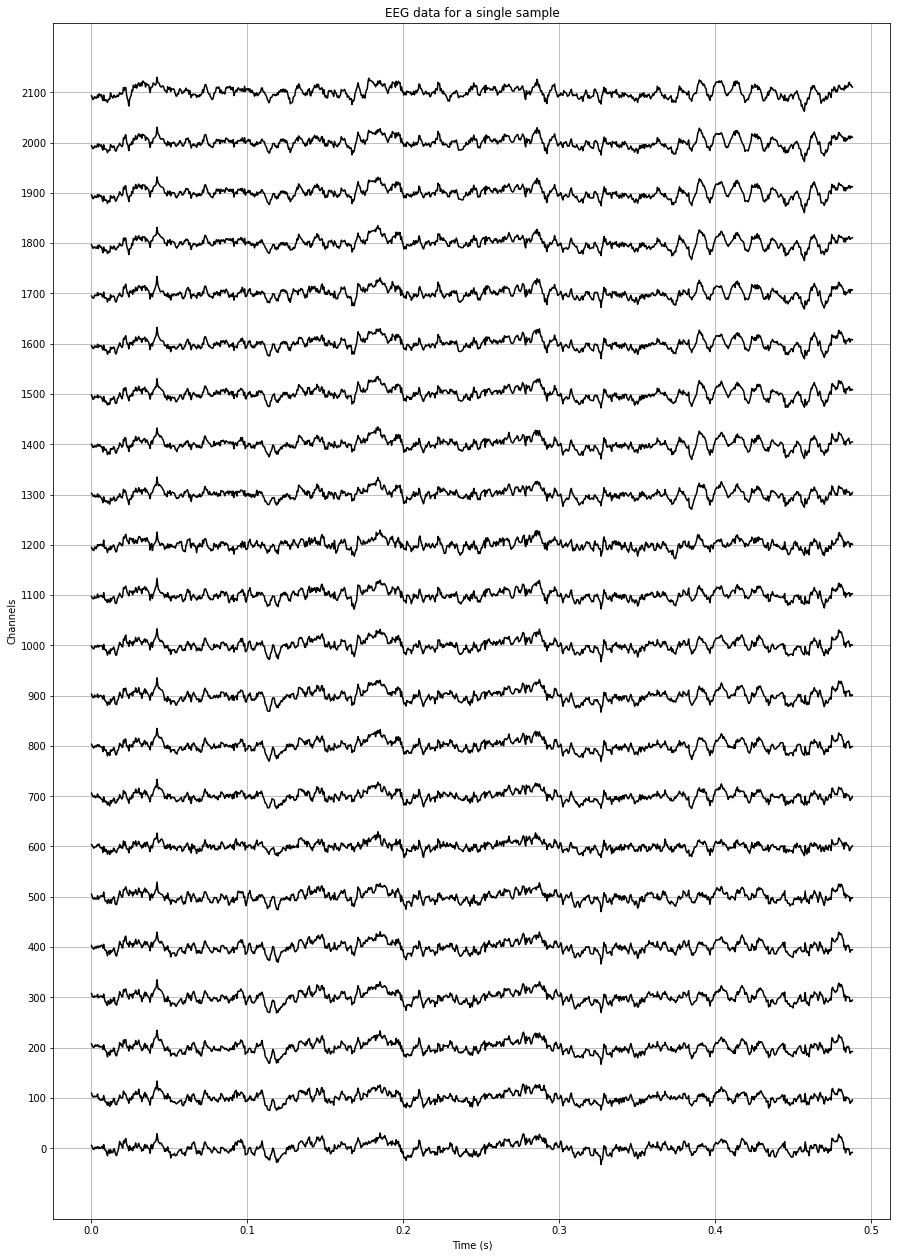

In [ ]:
figure(figsize=(15,22))
plot_eeg(X_train_valid[0])

# DATALOADER

In [ ]:
# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of training set after dimension reshaping: (6960, 250, 1, 22)
Shape of validation set after dimension reshaping: (1500, 250, 1, 22)
Shape of test set after dimension reshaping: (1772, 250, 1, 22)


In [ ]:
class LoadData(Dataset):
    def __init__(self, data, labels):
        self.transform = T.Compose([T.ToTensor(),
                                    T.Normalize((0.5), (0.5))
                                    ])
        self.data = data
        self.labels = labels

    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, index: int):
        input_data = self.data[index]
        input_data = self.transform(input_data)
        input_label = self.labels[index]
        return (input_data, input_label)

In [ ]:
train_dataset = LoadData(data=x_train, labels=y_train)
val_dataset = LoadData(data=x_valid, labels=y_valid)
train_dl = DataLoader(train_dataset, batch_size=16, num_workers=2,pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size=16, num_workers=2,pin_memory=True)

data = next(iter(train_dl))
input_data, input_labels = data
print(input_data.shape,  input_labels.shape)
print(len(train_dl), len(val_dl))

torch.Size([16, 22, 250, 1]) torch.Size([16])
435 94


# BASIC CNN MODEL

In [ ]:
class BasicCNNModel(nn.Module):
    def __init__(self):
        super(BasicCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(22, 25, (10, 1), stride=1, padding="same")
        self.bnorm1 = nn.BatchNorm2d(25)
        self.elu1 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d((3, 1))
        self.dropout1 = nn.Dropout(p=0.5)

        self.conv2 = nn.Conv2d(25, 50, (10, 1), stride=1, padding="same")
        self.bnorm2 = nn.BatchNorm2d(50)
        self.elu2 = nn.ELU()
        self.maxpool2 = nn.MaxPool2d((3, 1))
        self.dropout2 = nn.Dropout(p=0.5)

        self.conv3 = nn.Conv2d(50, 100, (10, 1), stride=1, padding="same")
        self.bnorm3 = nn.BatchNorm2d(100)
        self.elu3 = nn.ELU()
        self.maxpool3 = nn.MaxPool2d((3, 1))
        self.dropout3 = nn.Dropout(p=0.5)

        self.conv4 = nn.Conv2d(100, 200, (10, 1), stride=1, padding="same")
        self.bnorm4 = nn.BatchNorm2d(200)
        self.elu4 = nn.ELU()
        self.maxpool4 = nn.MaxPool2d((3, 1))
        self.dropout4 = nn.Dropout(p=0.5)  
        
        self.fc1 = nn.Linear(600, 4)    

    def forward(self, x):
        h = x
        h = self.conv1(h)
        h = self.bnorm1(h)
        h = self.elu1(h)
        h = self.maxpool1(h)
        h = self.dropout1(h)

        h = self.conv2(h)
        h = self.bnorm2(h)
        h = self.elu2(h)
        h = self.maxpool2(h)
        h = self.dropout2(h)

        h = self.conv3(h) 
        h = self.bnorm3(h)
        h = self.elu3(h)
        h = self.maxpool3(h)
        h = self.dropout3(h)

        h = self.conv4(h) 
        h = self.bnorm4(h)
        h = self.elu4(h)
        h = self.maxpool4(h)
        h = self.dropout4(h)

        h = torch.flatten(h, 1)

        h = self.fc1(h)

        return h


# DEEPCONVNET

In [ ]:
# https://arxiv.org/pdf/1703.05051.pdf

class DeepConvNet(nn.Module):
    def __init__(self):
        super(DeepConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 25, (1, 5), stride=1, padding=0)
        self.conv2 = nn.Conv2d(18, 25, (25, 22), stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(25)
        self.elu1 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        self.dropout1 = nn.Dropout(p=0.5)

        self.conv3 = nn.Conv2d(25, 50, (5, 1), stride=1, padding=0)
        self.bnorm2 = nn.BatchNorm2d(50)
        self.elu2 = nn.ELU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        self.dropout2 = nn.Dropout(p=0.5)

        self.conv4 = nn.Conv2d(50, 100, (5, 1), stride=1, padding=0)
        self.bnorm3 = nn.BatchNorm2d(100)
        self.elu3 = nn.ELU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        self.dropout3 = nn.Dropout(p=0.5)

        self.conv5 = nn.Conv2d(100, 200, (5, 1), stride=1, padding=0)
        self.bnorm4 = nn.BatchNorm2d(200)
        self.elu4 = nn.ELU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        self.dropout4 = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(8000, 4)
        self.softmax = nn.Softmax()

    def forward(self, x):
        h = x
        h = h.permute(0, 3, 2, 1)
        h = self.conv1(h)
        h = h.permute(0, 3, 2, 1)
        h = self.conv2(h)
        h = self.bnorm1(h)
        h = self.elu1(h)
        h = self.maxpool1(h)
        h = self.dropout1(h)

        h = self.conv3(h)
        h = self.bnorm2(h)
        h = self.elu2(h)
        h = self.maxpool2(h)
        h = self.dropout2(h)

        h = self.conv4(h) 
        h = self.bnorm3(h)
        h = self.elu3(h)
        h = self.maxpool3(h)
        h = self.dropout3(h)

        h = self.conv5(h) 
        h = self.bnorm4(h)
        h = self.elu4(h)
        h = self.maxpool4(h)
        h = self.dropout4(h)

        h = torch.flatten(h, 1)

        h = self.fc1(h)
        h = self.softmax(h)

        return h

# SHALLOWCONVNET

In [ ]:
# https://arxiv.org/pdf/1703.05051.pdf

class ShallowConvNet(nn.Module):
    def __init__(self):
        super(ShallowConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 40, (1, 13), stride=1, padding=0)
        self.conv2 = nn.Conv2d(10, 40, (40, 22), stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(40)
        self.avgpool1 = nn.AvgPool2d(kernel_size=(35, 1), stride=(7, 1))
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(19760, 4)
        self.softmax = nn.Softmax()

    def forward(self, x):
        h = x
        h = h.permute(0, 3, 2, 1)
        h = self.conv1(h)
        h = h.permute(0, 3, 2, 1)
        h = self.conv2(h)
        h = self.bnorm1(h)
        h = torch.square(h)
        h = self.avgpool1(h)
        h = torch.log(h)
        h = self.dropout1(h)

        h = torch.flatten(h, 1)

        h = self.fc1(h)
        h = self.softmax(h)

        return h

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Trainer:
    def __init__(self, epochs, batch_size, learning_rate, num_workers, train_data, valid_data, train_labels, valid_labels, patience, validate_after):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_workers = num_workers
        self.train_data = train_data
        self.valid_data = valid_data
        self.train_labels = train_labels
        self.valid_labels = valid_labels
        self.patience = patience
        self.validate_after = validate_after

    def train(self):
            
        the_last_loss = 100
        trigger_times = 0
        global_val_loss_minima = 100
            
        train_dataset = LoadData(data=self.train_data, labels=self.train_labels)
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, num_workers=self.num_workers,pin_memory=True)
        
        # CHANGE CLASS HERE
        model = DeepConvNet().to(device)
        model.double()
        model.apply(weights_init)
        
        criterion = torch.nn.CrossEntropyLoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(),lr=self.learning_rate, weight_decay=1e-6)

        for epoch in range(self.epochs):
            print("Starting Training Epoch " + str(epoch + 1))
            avg_loss = 0.0
            model.train()
            for i, data in enumerate(tqdm(train_dataloader)):
                inputs, targets = data
                inputs = inputs.to(device)
                targets = targets.to(device, dtype=torch.long)
                optimizer.zero_grad()

                outputs = model(inputs)

                loss = criterion(outputs, targets)

                writer.add_scalar("Loss/train", loss, epoch)

                loss.backward()
                optimizer.step()

                avg_loss += loss.item()

            print(f'Epoch {epoch + 1} \t\t Training Loss: {\
                avg_loss / len(train_dataloader)}')
            
            if (epoch + 1) % self.validate_after == 0:
                val_loss, val_len = self.validate(model, criterion, epoch)
                print(f'Epoch {epoch + 1} \t\t Validation Loss: {\
                    val_loss / val_len}')
                global_val_loss_minima = min(global_val_loss_minima, val_loss)
                if val_loss > global_val_loss_minima:
                    trigger_times += 1
                    print('trigger times:', trigger_times)

                    if trigger_times >= self.patience:
                        print('Early stopping!\nStart to test process.')
                        return best_model

                else:
                    print('trigger times: 0')
                    trigger_times = 0
                    best_model = model

                the_last_loss = val_loss
                
            torch.save(model.state_dict(), './Results/Models/saved_model_' + str(epoch + 1) + '.pth')

        return model


    def validate(self, model, criterion, epoch):
        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            valid_dataset = LoadData(data=self.valid_data, labels=self.valid_labels)
            valid_dataloader = DataLoader(valid_dataset, batch_size=self.batch_size, num_workers=self.num_workers,pin_memory=True)
            for i, data in enumerate(valid_dataloader):
                inputs, targets = data
                inputs = inputs.to(device)
                targets = targets.to(device, dtype=torch.long)

                outputs = model(inputs)

                loss = criterion(outputs, targets)
                writer.add_scalar("Loss/validation", loss, epoch)

                valid_loss += loss.item()
        return valid_loss, len(valid_dataloader)

In [ ]:
trainer = Trainer(epochs = 500, batch_size = 256, learning_rate = 0.0001, num_workers = 2, train_data=x_train, valid_data=x_valid, train_labels=y_train, valid_labels=y_valid, patience=10, validate_after=1)

In [ ]:
best_model = trainer.train()
writer.flush()

Starting Training Epoch 1


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 1 		 Training Loss: 1.4144575767111311


Epoch 1 		 Validation Loss: 1.3811128257150487
trigger times: 0
Starting Training Epoch 2


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 2 		 Training Loss: 1.387196293244714


Epoch 2 		 Validation Loss: 1.3804300296076324
trigger times: 0
Starting Training Epoch 3


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 3 		 Training Loss: 1.3708565565272042


Epoch 3 		 Validation Loss: 1.3721667223511482
trigger times: 0
Starting Training Epoch 4


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 4 		 Training Loss: 1.360175908375788


Epoch 4 		 Validation Loss: 1.369961134388561
trigger times: 0
Starting Training Epoch 5


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 5 		 Training Loss: 1.3438005050301862


Epoch 5 		 Validation Loss: 1.3530187141828045
trigger times: 0
Starting Training Epoch 6


100%|██████████| 7/7 [00:57<00:00,  8.27s/it]

Epoch 6 		 Training Loss: 1.3316678339061963


Epoch 6 		 Validation Loss: 1.3549569747109609
trigger times: 1
Starting Training Epoch 7


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 7 		 Training Loss: 1.31913976410818


Epoch 7 		 Validation Loss: 1.3392913138918472
trigger times: 0
Starting Training Epoch 8


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 8 		 Training Loss: 1.308028802953099


Epoch 8 		 Validation Loss: 1.3408806639571793
trigger times: 1
Starting Training Epoch 9


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 9 		 Training Loss: 1.2944043082796528


Epoch 9 		 Validation Loss: 1.3357164653376705
trigger times: 0
Starting Training Epoch 10


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 10 		 Training Loss: 1.2874499788955984


Epoch 10 		 Validation Loss: 1.337832515658857
trigger times: 1
Starting Training Epoch 11


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 11 		 Training Loss: 1.2841923898929732


Epoch 11 		 Validation Loss: 1.3362023972953467
trigger times: 2
Starting Training Epoch 12


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 12 		 Training Loss: 1.2677584030853182


Epoch 12 		 Validation Loss: 1.3377392424236128
trigger times: 3
Starting Training Epoch 13


100%|██████████| 7/7 [00:57<00:00,  8.27s/it]

Epoch 13 		 Training Loss: 1.250163641116328


Epoch 13 		 Validation Loss: 1.3275945736423704
trigger times: 0
Starting Training Epoch 14


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 14 		 Training Loss: 1.2417408560340013


Epoch 14 		 Validation Loss: 1.332284895296843
trigger times: 1
Starting Training Epoch 15


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 15 		 Training Loss: 1.2348886059400088


Epoch 15 		 Validation Loss: 1.3213586198140264
trigger times: 0
Starting Training Epoch 16


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 16 		 Training Loss: 1.2224773378993394


Epoch 16 		 Validation Loss: 1.314792114774752
trigger times: 0
Starting Training Epoch 17


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 17 		 Training Loss: 1.2042385868567032


Epoch 17 		 Validation Loss: 1.306472942707893
trigger times: 0
Starting Training Epoch 18


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 18 		 Training Loss: 1.197874535390515


Epoch 18 		 Validation Loss: 1.3089427855172757
trigger times: 1
Starting Training Epoch 19


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 19 		 Training Loss: 1.1928251450290919


Epoch 19 		 Validation Loss: 1.2986303636120127
trigger times: 0
Starting Training Epoch 20


100%|██████████| 7/7 [00:57<00:00,  8.27s/it]

Epoch 20 		 Training Loss: 1.1712158535005395


Epoch 20 		 Validation Loss: 1.3050399303993208
trigger times: 1
Starting Training Epoch 21


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 21 		 Training Loss: 1.1671234462318307


Epoch 21 		 Validation Loss: 1.2829942411693167
trigger times: 0
Starting Training Epoch 22


100%|██████████| 7/7 [00:57<00:00,  8.27s/it]

Epoch 22 		 Training Loss: 1.1544032019258499


Epoch 22 		 Validation Loss: 1.2819746567225643
trigger times: 0
Starting Training Epoch 23


100%|██████████| 7/7 [00:57<00:00,  8.27s/it]

Epoch 23 		 Training Loss: 1.1418804398366043


Epoch 23 		 Validation Loss: 1.2791055192764618
trigger times: 0
Starting Training Epoch 24


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 24 		 Training Loss: 1.1285224994838687


Epoch 24 		 Validation Loss: 1.2759042989037166
trigger times: 0
Starting Training Epoch 25


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 25 		 Training Loss: 1.1152801343818592


Epoch 25 		 Validation Loss: 1.2712095798305494
trigger times: 0
Starting Training Epoch 26


100%|██████████| 7/7 [00:57<00:00,  8.27s/it]

Epoch 26 		 Training Loss: 1.106422966547885


Epoch 26 		 Validation Loss: 1.2711881438962718
trigger times: 0
Starting Training Epoch 27


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 27 		 Training Loss: 1.0926245363016776


Epoch 27 		 Validation Loss: 1.2676287147362522
trigger times: 0
Starting Training Epoch 28


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 28 		 Training Loss: 1.0992209185931168


Epoch 28 		 Validation Loss: 1.2653476383922428
trigger times: 0
Starting Training Epoch 29


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 29 		 Training Loss: 1.0834802586137013


Epoch 29 		 Validation Loss: 1.2551568488106537
trigger times: 0
Starting Training Epoch 30


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 30 		 Training Loss: 1.068572523572049


Epoch 30 		 Validation Loss: 1.2622827396031608
trigger times: 1
Starting Training Epoch 31


100%|██████████| 7/7 [00:57<00:00,  8.27s/it]

Epoch 31 		 Training Loss: 1.0670198159605406


Epoch 31 		 Validation Loss: 1.2545212053783632
trigger times: 0
Starting Training Epoch 32


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 32 		 Training Loss: 1.0583898492792412


Epoch 32 		 Validation Loss: 1.2581908820748509
trigger times: 1
Starting Training Epoch 33


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 33 		 Training Loss: 1.0512594007849247


Epoch 33 		 Validation Loss: 1.2454283265413726
trigger times: 0
Starting Training Epoch 34


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 34 		 Training Loss: 1.0458292048640465


Epoch 34 		 Validation Loss: 1.2472334585681364
trigger times: 1
Starting Training Epoch 35


100%|██████████| 7/7 [00:57<00:00,  8.27s/it]

Epoch 35 		 Training Loss: 1.0468303280998517


Epoch 35 		 Validation Loss: 1.245002954320659
trigger times: 0
Starting Training Epoch 36


100%|██████████| 7/7 [00:57<00:00,  8.29s/it]

Epoch 36 		 Training Loss: 1.0450156525435674


Epoch 36 		 Validation Loss: 1.226859520751248
trigger times: 0
Starting Training Epoch 37


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 37 		 Training Loss: 1.0362027424292855


Epoch 37 		 Validation Loss: 1.2375816480663255
trigger times: 1
Starting Training Epoch 38


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 38 		 Training Loss: 1.0224600676037379


Epoch 38 		 Validation Loss: 1.227670267243254
trigger times: 2
Starting Training Epoch 39


100%|██████████| 7/7 [00:57<00:00,  8.27s/it]

Epoch 39 		 Training Loss: 1.0187626039694009


Epoch 39 		 Validation Loss: 1.2232978013875575
trigger times: 0
Starting Training Epoch 40


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 40 		 Training Loss: 1.0207928155030823


Epoch 40 		 Validation Loss: 1.2221445868765595
trigger times: 0
Starting Training Epoch 41


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 41 		 Training Loss: 1.0131643905745134


Epoch 41 		 Validation Loss: 1.225420739310139
trigger times: 1
Starting Training Epoch 42


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 42 		 Training Loss: 1.0041658053805183


Epoch 42 		 Validation Loss: 1.2169271210805959
trigger times: 0
Starting Training Epoch 43


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 43 		 Training Loss: 1.0035162413375172


Epoch 43 		 Validation Loss: 1.2135119533692578
trigger times: 0
Starting Training Epoch 44


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 44 		 Training Loss: 0.9994380487410622


Epoch 44 		 Validation Loss: 1.2087749576687372
trigger times: 0
Starting Training Epoch 45


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 45 		 Training Loss: 0.9924688611050713


Epoch 45 		 Validation Loss: 1.1981307010512885
trigger times: 0
Starting Training Epoch 46


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 46 		 Training Loss: 0.9899017332828154


Epoch 46 		 Validation Loss: 1.2167008134055703
trigger times: 1
Starting Training Epoch 47


100%|██████████| 7/7 [00:57<00:00,  8.29s/it]

Epoch 47 		 Training Loss: 0.9861428754422231


Epoch 47 		 Validation Loss: 1.2021106675088045
trigger times: 2
Starting Training Epoch 48


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 48 		 Training Loss: 0.9939553780465549


Epoch 48 		 Validation Loss: 1.1992689652852153
trigger times: 3
Starting Training Epoch 49


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 49 		 Training Loss: 0.9771721962457031


Epoch 49 		 Validation Loss: 1.2107307423379279
trigger times: 4
Starting Training Epoch 50


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 50 		 Training Loss: 0.9701637978905335


Epoch 50 		 Validation Loss: 1.2040810873372627
trigger times: 5
Starting Training Epoch 51


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 51 		 Training Loss: 0.9804851276292507


Epoch 51 		 Validation Loss: 1.1956905598675878
trigger times: 0
Starting Training Epoch 52


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 52 		 Training Loss: 0.970633889093617


Epoch 52 		 Validation Loss: 1.1966674152665209
trigger times: 1
Starting Training Epoch 53


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 53 		 Training Loss: 0.9708219286690044


Epoch 53 		 Validation Loss: 1.1898499184268116
trigger times: 0
Starting Training Epoch 54


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 54 		 Training Loss: 0.9592445314409341


Epoch 54 		 Validation Loss: 1.197188807285227
trigger times: 1
Starting Training Epoch 55


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 55 		 Training Loss: 0.9625898311345323


Epoch 55 		 Validation Loss: 1.2134357107557956
trigger times: 2
Starting Training Epoch 56


100%|██████████| 7/7 [00:57<00:00,  8.27s/it]

Epoch 56 		 Training Loss: 0.9667658081843077


Epoch 56 		 Validation Loss: 1.1911273263116873
trigger times: 3
Starting Training Epoch 57


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 57 		 Training Loss: 0.9562925466539463


Epoch 57 		 Validation Loss: 1.1855513043942765
trigger times: 0
Starting Training Epoch 58


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 58 		 Training Loss: 0.9518590926992481


Epoch 58 		 Validation Loss: 1.1955292190990372
trigger times: 1
Starting Training Epoch 59


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 59 		 Training Loss: 0.9487759995607756


Epoch 59 		 Validation Loss: 1.1960503851527673
trigger times: 2
Starting Training Epoch 60


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 60 		 Training Loss: 0.9497336685424901


Epoch 60 		 Validation Loss: 1.1925174573252368
trigger times: 3
Starting Training Epoch 61


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 61 		 Training Loss: 0.943445260654089


Epoch 61 		 Validation Loss: 1.188723076314691
trigger times: 4
Starting Training Epoch 62


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 62 		 Training Loss: 0.9417073496844915


Epoch 62 		 Validation Loss: 1.1828718397053477
trigger times: 0
Starting Training Epoch 63


100%|██████████| 7/7 [00:57<00:00,  8.27s/it]

Epoch 63 		 Training Loss: 0.9424135517015443


Epoch 63 		 Validation Loss: 1.1958724859497263
trigger times: 1
Starting Training Epoch 64


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 64 		 Training Loss: 0.9512295704994231


Epoch 64 		 Validation Loss: 1.2064062021650273
trigger times: 2
Starting Training Epoch 65


100%|██████████| 7/7 [00:57<00:00,  8.27s/it]

Epoch 65 		 Training Loss: 0.9299503986768728


Epoch 65 		 Validation Loss: 1.188835791947931
trigger times: 3
Starting Training Epoch 66


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 66 		 Training Loss: 0.9343790758338134


Epoch 66 		 Validation Loss: 1.1772108181867134
trigger times: 0
Starting Training Epoch 67


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 67 		 Training Loss: 0.9317961195752059


Epoch 67 		 Validation Loss: 1.1843784757361377
trigger times: 1
Starting Training Epoch 68


100%|██████████| 7/7 [00:57<00:00,  8.27s/it]

Epoch 68 		 Training Loss: 0.9371639685505719


Epoch 68 		 Validation Loss: 1.1756426212612228
trigger times: 0
Starting Training Epoch 69


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 69 		 Training Loss: 0.9328146744675225


Epoch 69 		 Validation Loss: 1.218590958057805
trigger times: 1
Starting Training Epoch 70


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 70 		 Training Loss: 0.9261613213871838


Epoch 70 		 Validation Loss: 1.195320067308001
trigger times: 2
Starting Training Epoch 71


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 71 		 Training Loss: 0.9235552333558531


Epoch 71 		 Validation Loss: 1.1573562944276903
trigger times: 0
Starting Training Epoch 72


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 72 		 Training Loss: 0.9189921002042719


Epoch 72 		 Validation Loss: 1.1830054384868216
trigger times: 1
Starting Training Epoch 73


100%|██████████| 7/7 [00:57<00:00,  8.27s/it]

Epoch 73 		 Training Loss: 0.9107885761319414


Epoch 73 		 Validation Loss: 1.2058516699388024
trigger times: 2
Starting Training Epoch 74


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 74 		 Training Loss: 0.9132879944560753


Epoch 74 		 Validation Loss: 1.1772489485744027
trigger times: 3
Starting Training Epoch 75


100%|██████████| 7/7 [00:57<00:00,  8.29s/it]

Epoch 75 		 Training Loss: 0.9151608665561347


Epoch 75 		 Validation Loss: 1.1667725367478774
trigger times: 4
Starting Training Epoch 76


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 76 		 Training Loss: 0.9085176346246281


Epoch 76 		 Validation Loss: 1.1751178899245809
trigger times: 5
Starting Training Epoch 77


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 77 		 Training Loss: 0.9127641030397476


Epoch 77 		 Validation Loss: 1.183090604533993
trigger times: 6
Starting Training Epoch 78


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 78 		 Training Loss: 0.9063699718887535


Epoch 78 		 Validation Loss: 1.18710755797684
trigger times: 7
Starting Training Epoch 79


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 79 		 Training Loss: 0.9048285966624744


Epoch 79 		 Validation Loss: 1.1752791670374734
trigger times: 8
Starting Training Epoch 80


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 80 		 Training Loss: 0.9139082252634766


Epoch 80 		 Validation Loss: 1.1570811150754086
trigger times: 0
Starting Training Epoch 81


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 81 		 Training Loss: 0.908344538202479


Epoch 81 		 Validation Loss: 1.1701776216944189
trigger times: 1
Starting Training Epoch 82


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 82 		 Training Loss: 0.902772441014197


Epoch 82 		 Validation Loss: 1.173015878022364
trigger times: 2
Starting Training Epoch 83


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 83 		 Training Loss: 0.9049528477784877


Epoch 83 		 Validation Loss: 1.169803484555132
trigger times: 3
Starting Training Epoch 84


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 84 		 Training Loss: 0.9016283868586347


Epoch 84 		 Validation Loss: 1.1494195112925234
trigger times: 0
Starting Training Epoch 85


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 85 		 Training Loss: 0.8979375461078859


Epoch 85 		 Validation Loss: 1.1670348413980847
trigger times: 1
Starting Training Epoch 86


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 86 		 Training Loss: 0.8943868720962149


Epoch 86 		 Validation Loss: 1.1656649578342582
trigger times: 2
Starting Training Epoch 87


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 87 		 Training Loss: 0.8913806263768009


Epoch 87 		 Validation Loss: 1.1679634379310664
trigger times: 3
Starting Training Epoch 88


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 88 		 Training Loss: 0.8923415635235962


Epoch 88 		 Validation Loss: 1.1598363859387657
trigger times: 4
Starting Training Epoch 89


100%|██████████| 7/7 [00:57<00:00,  8.29s/it]

Epoch 89 		 Training Loss: 0.8960012689193896


Epoch 89 		 Validation Loss: 1.1620534093523907
trigger times: 5
Starting Training Epoch 90


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 90 		 Training Loss: 0.8884936975543637


Epoch 90 		 Validation Loss: 1.1598785292546716
trigger times: 6
Starting Training Epoch 91


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 91 		 Training Loss: 0.8847078352032404


Epoch 91 		 Validation Loss: 1.1637189532449028
trigger times: 7
Starting Training Epoch 92


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 92 		 Training Loss: 0.8852416473972713


Epoch 92 		 Validation Loss: 1.165153922468014
trigger times: 8
Starting Training Epoch 93


100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

Epoch 93 		 Training Loss: 0.8809652288641691


Epoch 93 		 Validation Loss: 1.1548082303326677
trigger times: 9
Starting Training Epoch 94


100%|██████████| 7/7 [00:57<00:00,  8.28s/it]

Epoch 94 		 Training Loss: 0.8848417323783406


Epoch 94 		 Validation Loss: 1.1673721966228476
trigger times: 10
Early stopping!
Start to test process.


# TESTING

LOADING MODEL FROM CHECKPOINT

In [ ]:
model_no = 93

In [ ]:
model_test = ShallowConvNet()
model_test.load_state_dict(torch.load('./Results/Best_Models/250/ShallowConvNet.pth', map_location=torch.device('cpu')))
model_test.eval()
model_test.double()

ShallowConvNet(
  (conv1): Conv2d(1, 40, kernel_size=(1, 13), stride=(1, 1))
  (conv2): Conv2d(10, 40, kernel_size=(40, 22), stride=(1, 1))
  (bnorm1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool1): AvgPool2d(kernel_size=(35, 1), stride=(7, 1), padding=0)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=19760, out_features=4, bias=True)
  (softmax): Softmax(dim=None)
)

USING BEST MODEL FROM EARLY STOPPING

In [ ]:
model_test = best_model

In [ ]:
test_dataset = LoadData(data=x_test, labels=y_test)
test_dataloader = DataLoader(test_dataset, batch_size=16, num_workers=2,pin_memory=True)

In [ ]:
correct = 0
total = 0
for i, (inputs, targets) in enumerate(test_dataloader):
    # evaluate the model on the test set
    model_test.to(device)
    inputs = inputs.to(device, dtype=torch.double)
    targets = targets.to(device)
    outputs = model_test(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the test images: 58 %


In [ ]:
test_dataset = LoadData(data=x_test, labels=y_test)
test_dataloader = DataLoader(test_dataset, batch_size=16, num_workers=2,pin_memory=True)
for model_no in range(20, 104):
    model_test = DeepConvNet()
    model_test.load_state_dict(torch.load('./Results/Models/saved_model_' + str(model_no) + '.pth', map_location=torch.device('cpu')))
    model_test.eval()
    model_test.double()
    correct = 0
    total = 0
    for i, (inputs, targets) in enumerate(test_dataloader):
        # evaluate the model on the test set
        model_test.to(device)
        inputs = inputs.to(device, dtype=torch.double)
        targets = targets.to(device)
        outputs = model_test(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    print(f'Accuracy of model {model_no} on the test images: {100 * correct // total} %')